In [1]:
# paquetes
import pandas as pd
import numpy as np
import random
import math
import copy
import matplotlib.pyplot as plt

In [2]:
# lectura de archivos
df = pd.read_csv("datos-2025.tsv", sep="\t")
df.columns = [col.strip().lstrip('#') for col in df.columns]
X = df.iloc[:,0].values.tolist()
Y = df.iloc[:,1].values.tolist()


In [ ]:
# definición de operadores logicos
class Booleanos:
    def __init__(self, operador, hijos=None):
        self.operador = operador
        self.hijos = hijos or []

    def eval(self, x_val):
        # terminal: variable x o constante
        if not self.hijos:
            if self.operador == 'x':
                return x_val
            try:
                return float(self.operador)
            except ValueError:
                return 0.0
        valores = [c.eval(x_val) for c in self.hijos]
        
        if self.operador == 'ADD':
            return valores[0] + valores[1]
        if self.operador == 'SUB':
            return valores[0] - valores[1]
        if self.operador == 'MUL':
            return valores[0] * valores[1]
        if self.operador == 'DIV':
            try:
                return valores[0] / valores[1]
            except ZeroDivisionError:
                return 1.0
        if self.operador == 'POW':
            try:
                r = math.pow(valores[0], valores[1])
                return r if math.isfinite(r) else 1.0
            except Exception:
                return 1.0
        # primitiva unaria
        if self.operador == 'POW2':
            return  valores[0]**2
        
        if self.operador == 'POW3':
            return  valores[0]**3
        
        if self.operador == 'SIN':
            try:
                return math.sin(valores[0])
            except Exception:
                return 0.0
        if self.operador == 'COS':
            try:
                return math.cos(valores[0])
            except Exception:
                return 0.0
        if self.operador == 'EXP':
            try:
                return math.exp(valores[0])
            except Exception:
                return float('inf')
        if self.operador == 'LOG':
            try:
                return math.log(abs(valores[0]))
            except Exception:
                return 0.0
        if self.operador == 'SQRT':
            return math.sqrt(abs(valores[0]))
        if self.operador == 'NEG':
            return -valores[0]
        
        return 0.0

    def lectura(self):
        if not self.hijos:
            return self.operador
        # unarios
        if self.operador in ('SIN','COS','EXP','LOG','SQRT','NEG'):
            c = self.hijos[0].lectura()
            op = '-' if self.operador=='NEG' else self.operador.lower()
            return f"{op}({c})"
        # binarios
        l = self.hijos[0].lectura()
        r = self.hijos[1].lectura()
        op_sym = {'ADD':'+','SUB':'-','MUL':'*','DIV':'/','POW':'^'}[self.operador]
        return f"({l} {op_sym} {r})"

In [4]:
# conjunto de funciones
FUNCIONES = [ ('ADD',2), ('SUB',2), ('MUL',2), ('DIV',2), ('POW',2),
              ('SIN',1), ('COS',1), ('EXP',1), ('LOG',1), ('SQRT',1), ('NEG',1) ]
T = ['x']

In [5]:
# definición de estructura de árbol
def gen_arbol(max_p):
    def crecer(p):
        if p >= max_p or (p>0 and random.random()<0.3):
            if random.random()<0.5:
                return Booleanos('x')
            return Booleanos(str(round(random.uniform(-10,10),2)))
        name, arity = random.choice(FUNCIONES)
        return Booleanos(name, [ crecer(p+1) for _ in range(arity) ])
    return crecer(0)

In [6]:
# descendencia

def descendencia(node):
    lst = [(None,None,node)]
    for i,h in enumerate(node.hijos):
        for p,idx,n in descendencia(h):
            padre = node if p is None else p
            pos = i if p is None else idx
            lst.append((padre,pos,n))
    return lst

# cruza
def cruza(padre1, padre2):
    n1 = copy.deepcopy(padre1)
    n2 = copy.deepcopy(padre2)
    v1 = descendencia(n1)
    v2 = descendencia(n2)
    p1,i1,s1 = random.choice(v1)
    p2,i2,s2 = random.choice(v2)
    if p1 is None:
        c1 = s2
    else:
        p1.hijos[i1] = s2
        c1 = n1
    if p2 is None:
        c2 = s1
    else:
        p2.hijos[i2] = s1
        c2 = n2
    return c1,c2

# mutación
def muta(arbol, max_p):
    t = copy.deepcopy(arbol)
    hojas = descendencia(t)
    p,i,_ = random.choice(hojas)
    sub = gen_arbol(max_p)
    if p is None:
        return sub
    p.hijos[i] = sub
    return t

In [7]:
# Fitness 
def fit(ind):
    errores = []
    for x,y in zip(X,Y):
        pred = ind.eval(x)
        try:
            errores.append((pred-y)**2)
        except Exception:
            errores.append(float('inf'))
    return sum(errores)/len(errores)

In [8]:
# parámetros
k = 3               # torneo
ngen = 100           # número de generaciones
pob_size = 100      # tamaño de la población
prob_cruza = 0.8    # probabilidad de cruza
prob_muta = 0.1     # probabilidad de mutación
max_p = 4           # máxima profundidad

In [9]:
# torneo de k individuos
def torneo(pob, k=3):
    return min(random.sample(pob,k), key=lambda ind: ind_fit[ind])

In [10]:
# programación genética
def PG(ngen, pob_size, prob_cruza, prob_muta, max_p):
    pob = [gen_arbol(max_p) for _ in range(pob_size)]

    for ind in pob:
        ind_fit[ind] = fit(ind)
    top = min(pob, key=lambda i: ind_fit[i])
    no_mejora=0
    for gen in range(1,ngen+1):
        nueva=[]

        while len(nueva)<pob_size:
            p1 = torneo(pob)
            p2 = torneo(pob)
            if random.random()<prob_cruza:
                c1,c2 = cruza(p1,p2)
            else:
                c1,c2 = copy.deepcopy(p1), copy.deepcopy(p2)
            if random.random()<prob_muta:
                c1 = muta(c1, max_p)
            if random.random()<prob_muta:
                c2 = muta(c2, max_p)
            nueva.extend([c1,c2])
        pob = nueva
        
        for ind in pob:
            ind_fit[ind] = fit(ind)
        curr = min(pob, key=lambda i: ind_fit[i])
        if ind_fit[curr] < ind_fit[top]:
            top, no_mejora = curr,0
        else:
            no_mejora = no_mejora + 1
        print(f"Gen {gen:02d} mejor MEC = {ind_fit[top]:.4f}")
        if no_mejora >=10: break

    return top, ind_fit[top]

Gen 01 mejor MEC = 6623130.4759
Gen 02 mejor MEC = 6623130.4759
Gen 03 mejor MEC = 6528519.3250
Gen 04 mejor MEC = 6462826.6308
Gen 05 mejor MEC = 6462826.6308
Gen 06 mejor MEC = 6457836.4611
Gen 07 mejor MEC = 6420439.2916
Gen 08 mejor MEC = 6420439.2916
Gen 09 mejor MEC = 6420439.2916
Gen 10 mejor MEC = 6420439.2916
Gen 11 mejor MEC = 6420439.2916
Gen 12 mejor MEC = 6420439.2916
Gen 13 mejor MEC = 6420439.2916
Gen 14 mejor MEC = 6420439.2916
Gen 15 mejor MEC = 6046187.7313
Gen 16 mejor MEC = 6046187.7313
Gen 17 mejor MEC = 6046187.7313
Gen 18 mejor MEC = 5906589.7005
Gen 19 mejor MEC = 5132073.4416
Gen 20 mejor MEC = 4989751.9529
Gen 21 mejor MEC = 4989751.9529
Gen 22 mejor MEC = 4937095.0541
Gen 23 mejor MEC = 4882553.4594
Gen 24 mejor MEC = 4882553.4594
Gen 25 mejor MEC = 4882553.4594
Gen 26 mejor MEC = 4882553.4594
Gen 27 mejor MEC = 4563274.5777
Gen 28 mejor MEC = 4563274.5777
Gen 29 mejor MEC = 4517333.7606
Gen 30 mejor MEC = 4517333.7606
Gen 31 mejor MEC = 4517333.7606
Gen 32 m

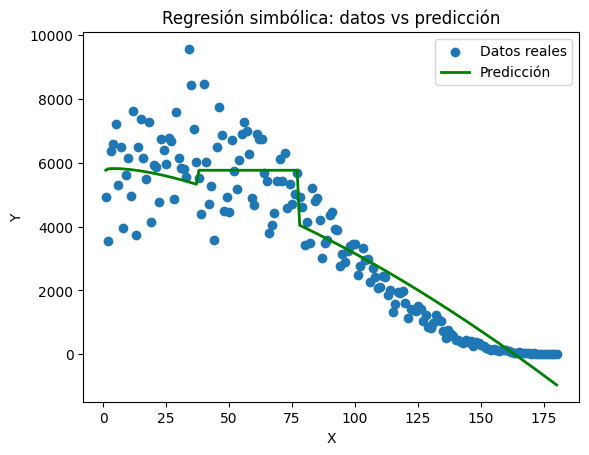

In [14]:
if __name__ == "__main__":
    top, top_err = PG(ngen, pob_size, prob_cruza, prob_muta, max_p)
    print("\nMejor expresión:", top.lectura())
    print(f"MEC: {top_err:.6f}")

    y_pred = [top.eval(x) for x in X]

    plt.figure()
    plt.scatter(X, Y, label='Datos reales')
    xs, preds = zip(*sorted(zip(X, y_pred)))
    plt.plot(xs, preds, label='Predicción', linewidth=2, color='green') 
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Regresión simbólica: datos vs predicción')
    plt.legend()
    plt.show()
